In [200]:
import dask.array
from dask_image.ndinterp import affine_transform
#from scipy.ndimage import affine_transform
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math

In [201]:
ds = xr.open_dataset("C:\\Users\\Norman\\EOData\\SST-CCI\\2010\\20100101120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_LT-v02.0-fv01.1.nc")
ds

<xarray.Dataset>
Dimensions:                 (bnds: 2, lat: 3600, lon: 7200, time: 1)
Coordinates:
  * time                    (time) datetime64[ns] 2010-01-01T12:00:00
  * lat                     (lat) float32 -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon                     (lon) float32 -180.0 -179.9 -179.9 ... 179.9 180.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds               (time, bnds) datetime64[ns] ...
    lat_bnds                (lat, bnds) float32 ...
    lon_bnds                (lon, bnds) float32 ...
    analysed_sst            (time, lat, lon) float32 ...
    analysis_error          (time, lat, lon) float32 ...
    sea_ice_fraction        (time, lat, lon) float32 ...
    sea_ice_fraction_error  (time, lat, lon) float32 ...
    mask                    (time, lat, lon) float32 ...
Attributes:
    title:                           ESA SST CCI OSTIA L4 product
    references:                      http://www.esa-sst-cci.org
    institution:                     ESACCI
    history:                         Created using OSTIA reanalysis system v2.0
    license:                         GHRSST protocol describes data use as fr...
    naming_authority:                org.ghrsst
    uuid:                            19b1f7a4-d8d1-44eb-9cfa-37cc33c4c2c1
    tracking_id:                     19b1f7a4-d8d1-44eb-9cfa-37cc33c4c2c1
    gds_version_id:                  2.0
    netcdf_version_id:               4.1.3
    file_quality_level:              3
    spatial_resolution:              0.05 degree
    date_created:                    20130309T132046Z
    start_time:                      20100101T000000Z
    time_coverage_start:             20100101T000000Z
    stop_time:                       20100101T235959Z
    time_coverage_end:               20100101T235959Z
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    metadata_link:                   http://www.esa-cci.org
    keywords:                        Oceans > Ocean Temperature > Sea Surface...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       0.05
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       0.05
    geospatial_vertical_min:         -0.2
    geospatial_vertical_max:         -0.2
    acknowledgment:                  Funded by ESA
    creator_name:                    ESA SST CCI
    creator_email:                   science.leader@esa-sst-cci.org
    creator_url:                     http://www.esa-sst-cci.org
    project:                         Climate Change Initiative - European Spa...
    creator_processing_institution:  These data were produced at the Met Offi...
    publisher_name:                  ESACCI
    publisher_url:                   http://www.esa-sst-cci.org
    publisher_email:                 science.leader@esa-sst-cci.org
    comment:                         WARNING Some applications are unable to ...
    westernmost_longitude:           -180.0
    easternmost_longitude:           180.00002
    southernmost_latitude:           -90.0
    northernmost_latitude:           90.0
    geospatial_lat_max:              90.0
    geospatial_lat_min:              -90.0
    geospatial_lon_max:              180.0
    geospatial_lon_min:              -180.0
    processing_level:                L4
    cdm_data_type:                   grid
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Conventions:                     CF-1.5, Unidata Observation Dataset v1.0
    source:                          ATSR<1,2>-ESACCI-L3U-v1.0, AATSR-ESACCI-...
    platform:                        ERS-<1,2>, Envisat, NOAA-<12,14,15,16,17...
    sensor:                          ATSR, AATSR, AVHRR_GAC
    id:                              OSTIA-ESACCI-L4-v01.1
    product_version:    

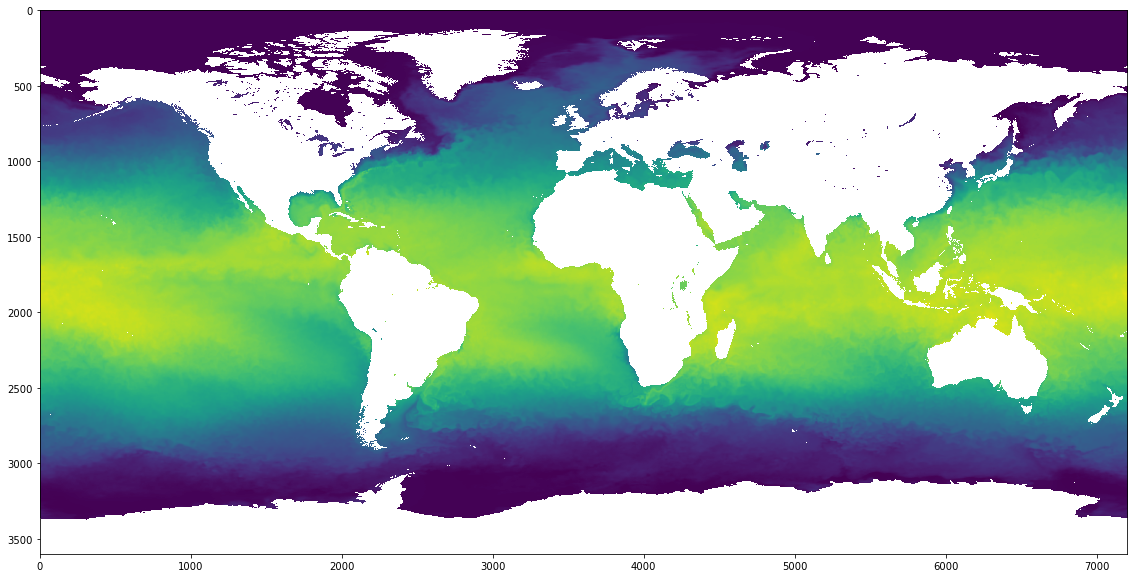

In [202]:
im0 = ds.analysed_sst[0].values[::-1,...]
plt.figure(figsize=(20,10))
plt.imshow(im0)

In [235]:
im1 = im0[750:850,3450:3550]

In [236]:
vmin, vmax = np.nanmin(im), np.nanmax(im)
imp = dict(vmin=vmin, vmax=vmax, cmap='gray')
maskp = dict(vmin=0, vmax=1, cmap='gray')
im1.dtype, im1.shape, vmin, vmax

(dtype('float32'), (100, 100), 279.0, 285.24)

In [237]:
filled_im1 = np.where(np.isnan(im1), 0, im1)

In [238]:
mask1 = np.where(np.isnan(im1), 1.0, 0.0)

In [239]:
def plot_3(im1, im2, im3):
    fig = plt.figure(1, figsize=(20,20))
    fig.add_subplot(1, 3, 1)
    plt.imshow(im1, **maskp)
    fig.add_subplot(1, 3, 2)
    plt.imshow(im2, **imp)
    fig.add_subplot(1, 3, 3)
    plt.imshow(im3, **imp)

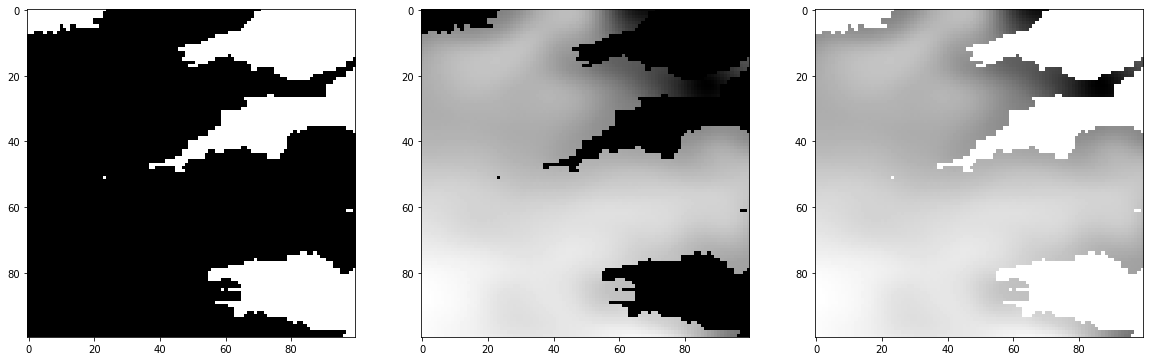

In [240]:
plot_3(mask1, filled_im1, im1)

In [241]:
def scale(im, mask, scale):
    matrix = [
        [1/scale, 0.0, 0],
        [0.0, 1/scale, 0],
    ]
    filled_im = np.where(mask, 0, im)
    output_shape = round(im.shape[0] * scale), round(im.shape[1] * scale)
    scaled_im = affine_transform(filled_im, matrix, order=1, output_shape=output_shape, mode='constant', cval=0.0)
    scaled_mask = affine_transform(1.0 - mask, matrix, order=1, output_shape=output_shape, mode='constant', cval=0.0)
    scaled_im_nan = np.where(scaled_mask == 0, np.nan, scaled_im / scaled_mask)
    return scaled_mask, scaled_im, scaled_im_nan

C:\Users\Norman\Miniconda3\envs\xcube\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


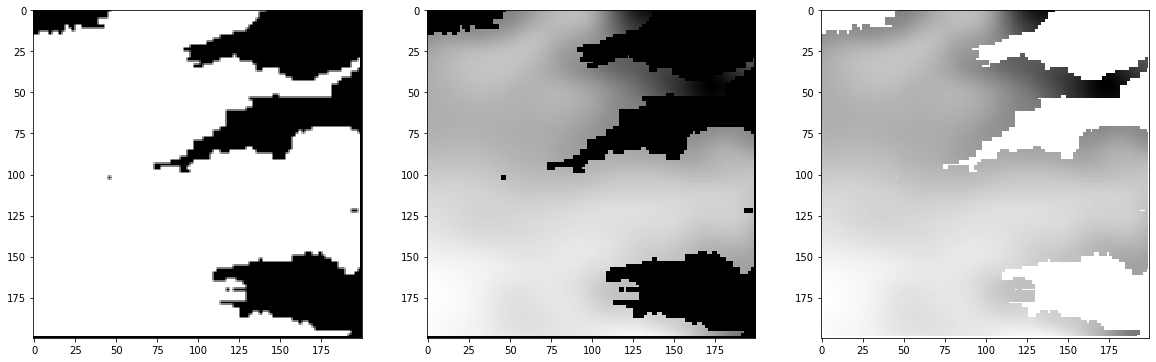

In [242]:
plot_3(*scale(im1, mask1, 2))

C:\Users\Norman\Miniconda3\envs\xcube\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


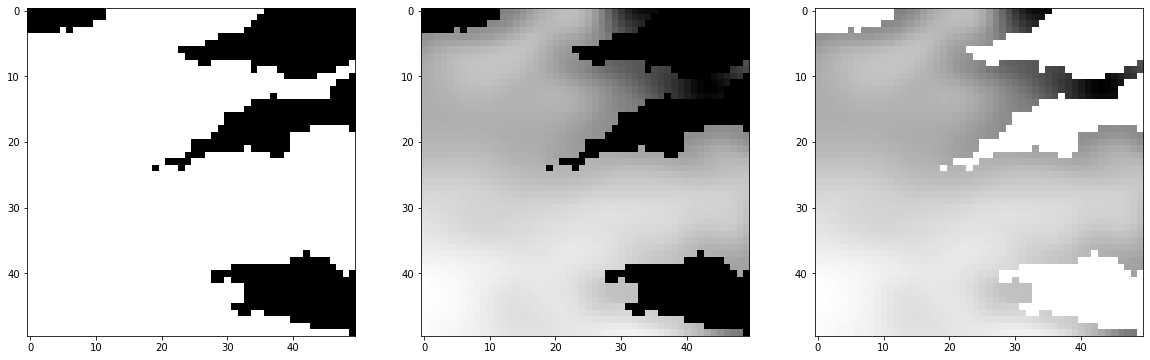

In [243]:
plot_3(*scale(im1, mask1, 0.5))

In [355]:
def _get_scaled_shape(shape, scale, divisor=1):
    wf = shape[-1] * scale
    hf = shape[-2] * scale
    if divisor > 1:
        w = divisor * ((round(wf) + divisor - 1) // divisor)
        h = divisor * ((round(hf) + divisor - 1) // divisor)
    else:
        w = math.ceil(wf)
        h = math.ceil(hf)     
    return im.shape[0:-2] + (h, w)


def _is_no_op(im, scale, offset, shape):
    if math.isclose(scale, 1) and (shape is None or shape == im.shape):
        if offset is None:
            return True
        offset_y, offset_x = offset
        return math.isclose(offset_x, 0) and math.isclose(offset_y, 0)
    return False

def _affine_transform(im, scale: float, offset=None, shape=None, nearest=False):
    if not isinstance(im, dask.array.Array):
        im = dask.array.from_array(im)
    if _is_no_op(im, scale, offset, shape):
        return im
    if shape is None:
        shape = _get_scaled_shape(im.shape, scale)
    inv_scale = 1 / scale
    matrix = [
        [inv_scale, 0.0],
        [0.0, inv_scale],
    ]
    output_shape = shape if shape is not None else _get_scaled_shape(im.shape, scale) 
    at_kwargs = dict(
        offset=np.array([offset[0], offset[1]]) if offset is not None else np.array([0.0, 0.0]), 
        order=0 if nearest else 1, 
        output_shape=output_shape, 
        output_chunks=output_shape, 
        mode='constant',
        cval=0.0
    )
    mask = dask.array.isnan(im)
    if dask.array.any(mask):
        filled_im = dask.array.where(mask, 0.0, im)
        scaled_im = affine_transform(filled_im, matrix, **at_kwargs)
        scaled_norm = affine_transform(1.0 - mask, matrix, **at_kwargs)
        return dask.array.where(dask.array.isclose(scaled_norm, 0.0), np.nan, scaled_im / scaled_norm)
    else:
        at_kwargs.update(cval=np.nan)
        return affine_transform(im, matrix, **at_kwargs)


def resample(im, scale: float, offset=None, shape=None, nearest=False, aggregator=np.nanmean):
    inv_scale = 1 / scale
    divisor = math.ceil(inv_scale)
    if divisor >= 2 and aggregator is not None:
        dims = len(im.shape)
        axes = {dims-2: divisor, dims-1: divisor}
        elongation = divisor / inv_scale
        new_shape = _get_scaled_shape(shape or im.shape, divisor, divisor=divisor)
        im = _affine_transform(im, elongation, offset=offset, shape=new_shape, nearest=nearest)
        print('Downsampling:', scale, inv_scale, divisor, elongation, 1 / elongation, new_shape, im.shape, im.chunks)
        im = dask.array.coarsen(aggregator, im, axes)
        if shape and shape != im.shape:
            return im[..., 0:shape[-2], 0:shape[-1]]
        return im
    else:
        print('Upsampling:', scale)
        return _affine_transform(im, scale, offset=offset, shape=shape, nearest=nearest)


Upsampling: 1


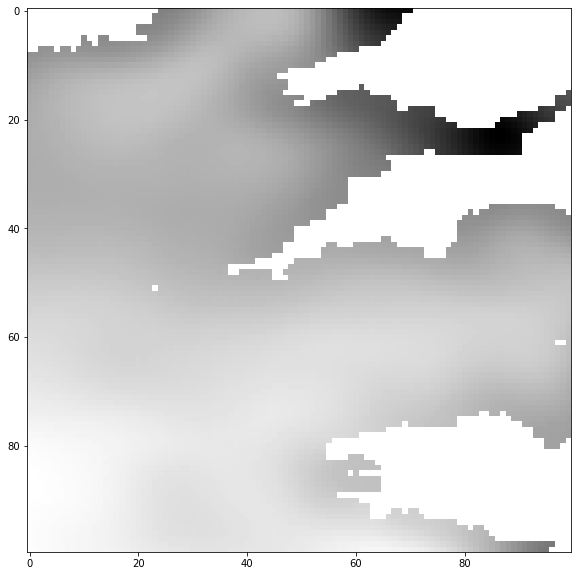

In [356]:
im10 = resample(im0, 1, offset=(750,3450), shape=(100,100))
plt.figure(figsize=(10,10))
plt.imshow(im10, **imp)

Downsampling: 0.5 2.0 2 1.0 1.0 (100, 100) (100, 100) ((100,), (100,))


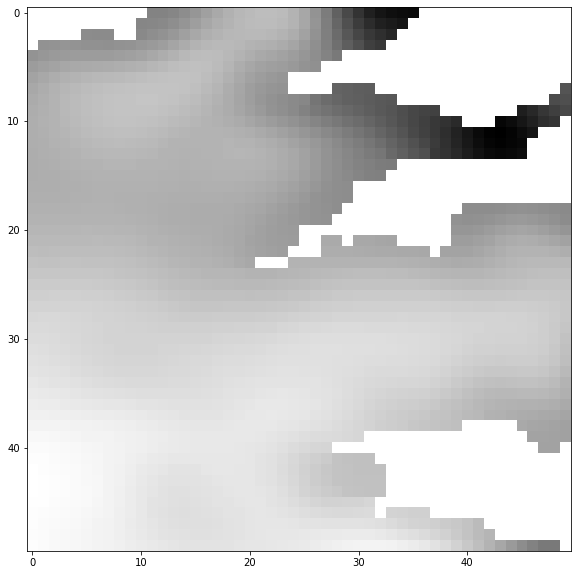

In [357]:
im05 = resample(im0, 0.5, offset=(750,3450), shape=(50,50))
plt.figure(figsize=(10,10))
plt.imshow(im05, **imp)

Downsampling: 0.25 4.0 4 1.0 1.0 (100, 100) (100, 100) ((100,), (100,))


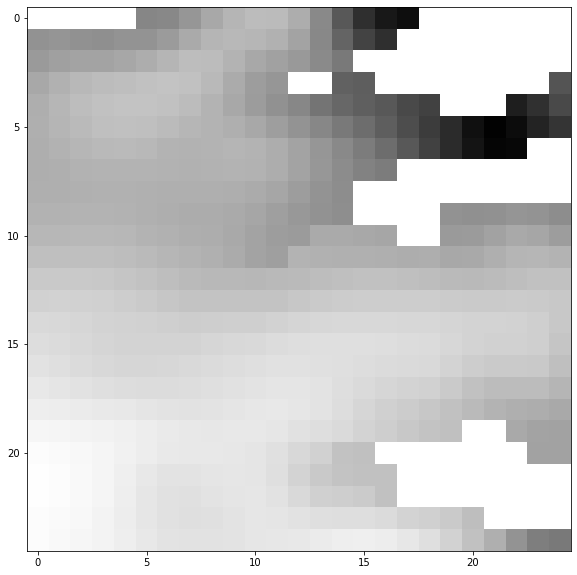

In [358]:
im025 = resample(im0, 0.25, offset=(750,3450), shape=(25,25))
plt.figure(figsize=(10,10))
plt.imshow(im025, **imp)

Downsampling: 0.3 3.3333333333333335 4 1.2 0.8333333333333334 (132, 132) (132, 132) ((132,), (132,))


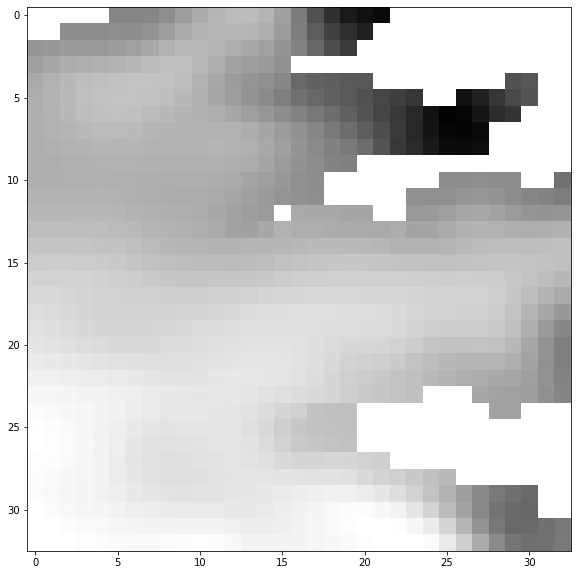

In [359]:
im03 = resample(im0, 0.3, offset=(750,3450), shape=(33,33))
plt.figure(figsize=(10,10))
plt.imshow(im03, **imp)

Downsampling: 0.21 4.761904761904762 5 1.05 0.9523809523809523 (125, 125) (125, 125) ((125,), (125,))


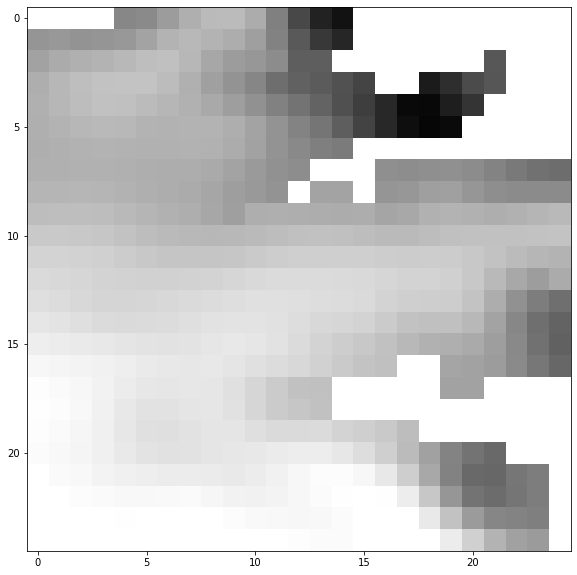

In [360]:
im021 = resample(im0, 0.21, offset=(750,3450), shape=(25,25))
plt.figure(figsize=(10,10))
plt.imshow(im021, **imp)

Upsampling: 2.5


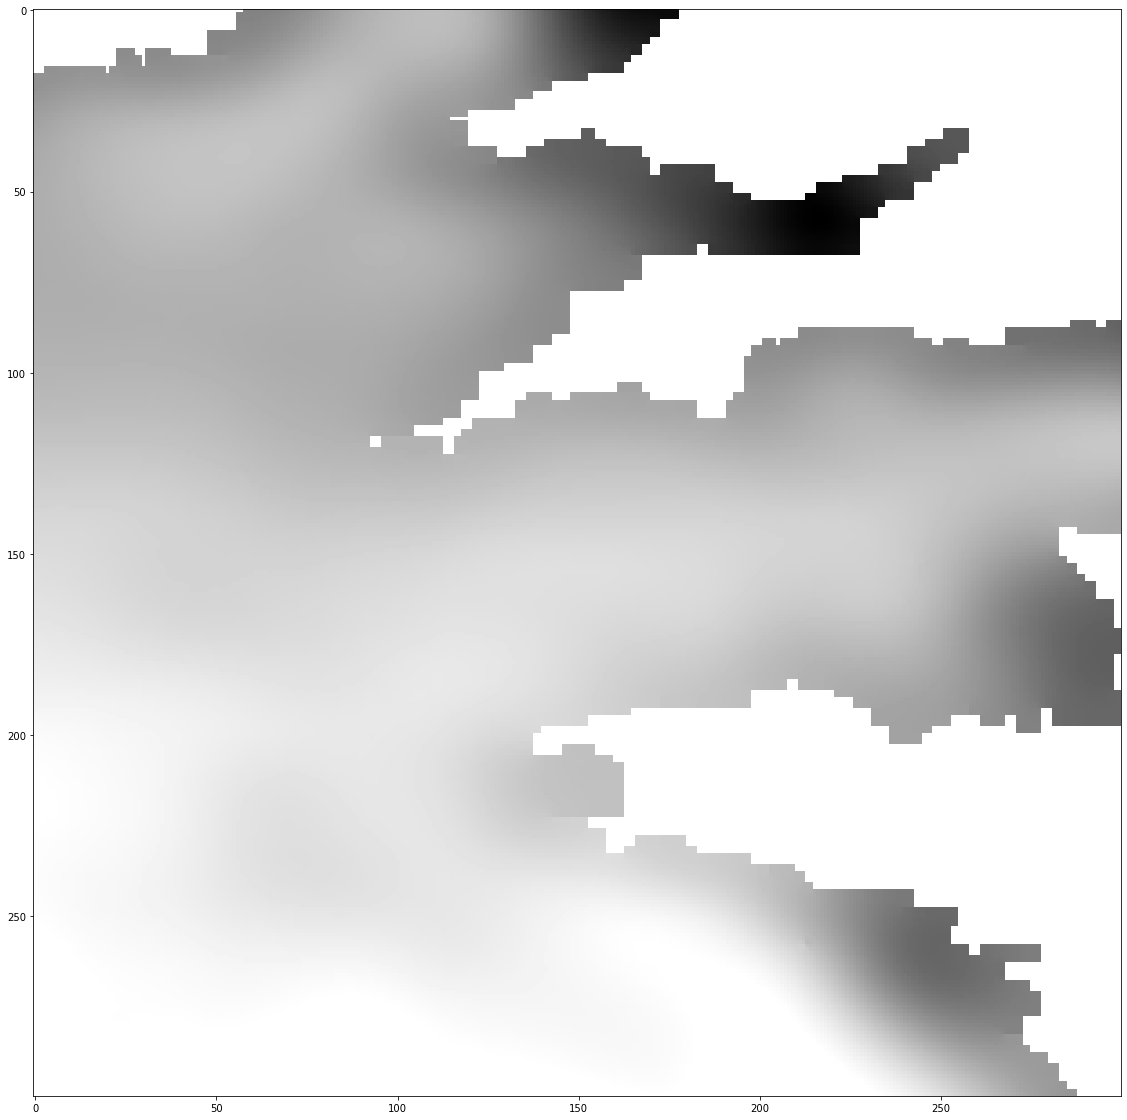

In [361]:
im25 = resample(im0, 2.5, offset=(750,3450), shape=(300,300))
plt.figure(figsize=(20,20))
plt.imshow(im25, **imp)

----

In [364]:
scales = [1/4, 3/10, 1/3, 1/2, 2/3, 3/4, 1, 4/3, 3/2, 2/1, 3/1, 10/3, 4/1]

Downsampling: 0.25 4.0 4 1.0 1.0 (100, 100) (100, 100) ((100,), (100,))
Upsampling: 4.0
mean_sqr_root =  0.10586162475524397 , num_valids = 7273
Downsampling: 0.3 3.3333333333333335 4 1.2 0.8333333333333334 (120, 120) (120, 120) ((120,), (120,))
Upsampling: 3.3333333333333335
mean_sqr_root =  0.08888363261439762 , num_valids = 7273
Downsampling: 0.3333333333333333 3.0 3 1.0 1.0 (102, 102) (102, 102) ((102,), (102,))
Upsampling: 3.0
mean_sqr_root =  0.07189265271236155 , num_valids = 7687
Downsampling: 0.5 2.0 2 1.0 1.0 (100, 100) (100, 100) ((100,), (100,))
Upsampling: 2.0
mean_sqr_root =  0.035835446170203324 , num_valids = 7547
Downsampling: 0.6666666666666666 1.5 2 1.3333333333333333 0.75 (134, 134) (134, 134) ((134,), (134,))
Upsampling: 1.5
mean_sqr_root =  0.027544486207110964 , num_valids = 7687
Downsampling: 0.75 1.3333333333333333 2 1.5 0.6666666666666666 (150, 150) (150, 150) ((150,), (150,))
Upsampling: 1.3333333333333333
mean_sqr_root =  0.02422223452036969 , num_valids = 7

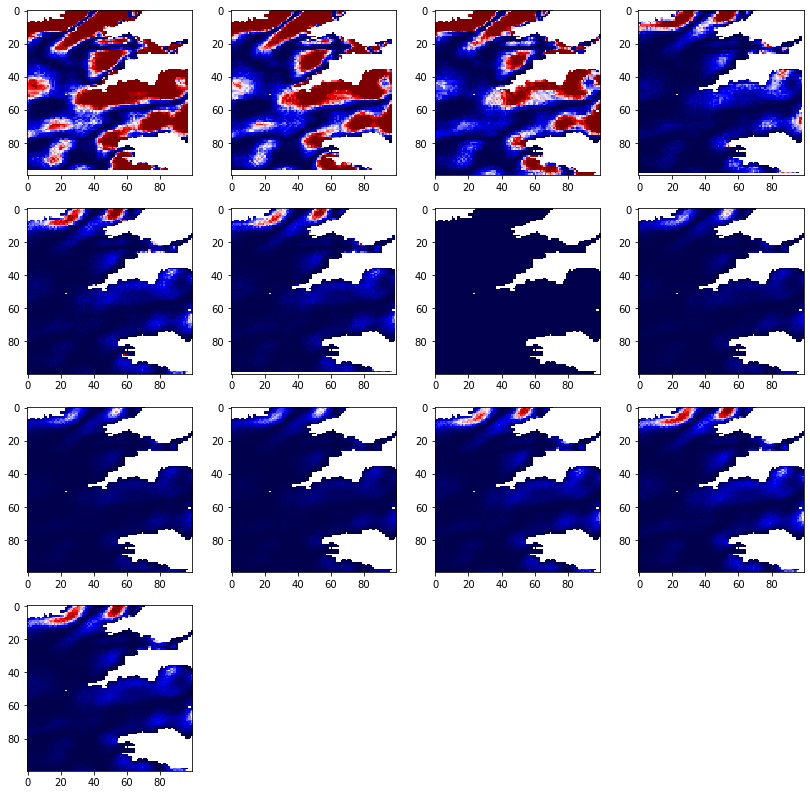

In [366]:
import warnings 
warnings.filterwarnings('ignore')

ref_im = dask.array.from_array(im0[750:850, 3450:3550])
h, w = ref_im.shape

rows = 4
cols = 4
fig = plt.figure(1, figsize=(14,14))
for i in range(len(scales)):
    scale = scales[i]
    scaled_im = resample(im0, scale, offset=(750,3450), shape=_get_scaled_shape(ref_im.shape, scale))
    restored_im = resample(scaled_im, 1/scale, offset=(0,0), shape=ref_im.shape)
    diff_im = (ref_im - restored_im) * (ref_im - restored_im)
    num_valids = int(w * h - dask.array.sum(dask.array.isnan(diff_im)))
    mean_sqr_root = math.sqrt(dask.array.nansum(diff_im) / num_valids)
    print('mean_sqr_root = ', mean_sqr_root, ', num_valids =', num_valids)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(diff_im, cmap='seismic', vmin=0.0, vmax=0.01)
    #plt.imshow(scaled_im)
    #plt.imshow(restored_im)

